# Tìm Bounding box trong object detection 

In [66]:
import cv2
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

url = 'https://i0.wp.com/cdn-images-1.medium.com/max/2400/1*LmxW8FDfXZJl5yvESvjP7Q.jpeg?resize=660%2C373&ssl=1'
# Ham download tác duchj tải convert ảnh sang numpy aray từ đầu vào là link 
def _downloadImage(url):
  resp = requests.get(url)
  img = np.asarray(bytearray(resp.content), dtype="uint8")
  img = cv2.imdecode(img, cv2.IMREAD_COLOR)
  return img
img = _downloadImage(url)

(<matplotlib.axes._subplots.AxesSubplot at 0x1f2745eb908>,
 Text(0.5, 1.0, 'Gray of Binary Image'))

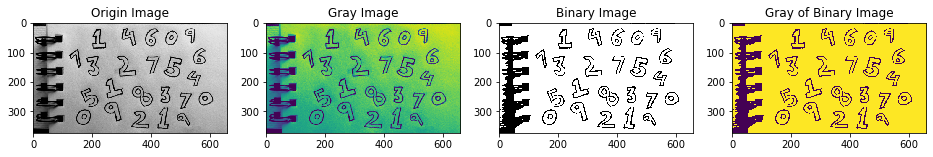

In [67]:
# Chuyển ảnh sang gray image
imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Chuyển sang ảnh nhị phân 
_, imgBi = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)
# Chuyển anh sang gray image
imgGrayBi = cv2.cvtColor(imgBi, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(16, 4))
plt.subplot(141), plt.imshow(img), plt.title('Origin Image')
plt.subplot(142), plt.imshow(imgGray), plt.title('Gray Image')
plt.subplot(143), plt.imshow (imgBi), plt.title('Binary Image')
plt.subplot(144), plt.imshow (imgGrayBi), plt.title('Gray of Binary Image')

In [68]:
contours, hierarchy = cv2.findContours(imgGrayBi, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# Sắp xếp các contour theo diện tích giảm dần:
area_cnt = [cv2.contourArea(cnt) for cnt in contours]
area_sort = np.argsort(area_cnt)[::-1]
# Top 20 contour có diện tích lớn nhất
area_sort[:2]

array([45, 78], dtype=int64)

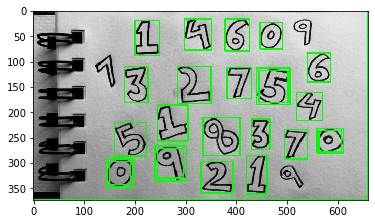

In [71]:
def _drawBoundingBox(img, cnt):
  x,y,w,h = cv2.boundingRect(cnt)
  img = cv2.rectangle(img, (x,y),(x+w,y+h),(0,255,0),2)
  return img

imgOrigin = img.copy()
# Vẽ bounding box cho 25 contours có diện tích lớn nhất
for i in area_sort[:25]:
  cnt = contours[i]
  imgOrigin = _drawBoundingBox(imgOrigin, cnt)
  
plt.imshow(imgOrigin)

# Non-max suppression (loại bỏ overlap)

In [94]:
import numpy as np

def non_max_suppression(boxes, overlapThresh):
  '''
  boxes: List các bounding box
  overlapThresh: Ngưỡng overlapping giữa các hình ảnh
  '''
  # Nếu không có bounding boxes thì trả về empty list
  if len(boxes)==0:
    return []
  # Nếu bounding boxes nguyên thì chuyển sang float.
  if boxes.dtype.kind == "i":
    boxes = boxes.astype("float")

  # Khởi tạo list của index được lựa chọn
  pick = []

  # Lấy ra tọa độ của các bounding boxes
  x1 = boxes[:,0]
  y1 = boxes[:,1]
  x2 = boxes[:,2]
  y2 = boxes[:,3]

  # Tính toàn diện tích của các bounding boxes và sắp xếp chúng theo thứ tự từ bottom-right, chính là tọa độ theo y của bounding box
  area = (x2 - x1 + 1) * (y2 - y1 + 1)
  idxs = np.argsort(y2)
  # Khởi tạo một vòng while loop qua các index xuất hiện trong indexes
  while len(idxs) > 0:
    # Lấy ra index cuối cùng của list các indexes và thêm giá trị index vào danh sách các indexes được lựa chọn
    last = len(idxs) - 1
    i = idxs[last]
    pick.append(i)

    # Tìm cặp tọa độ lớn nhất (x, y) là điểm bắt đầu của bounding box và tọa độ nhỏ nhất (x, y) là điểm kết thúc của bounding box
    xx1 = np.maximum(x1[i], x1[idxs[:last]])
    yy1 = np.maximum(y1[i], y1[idxs[:last]])
    xx2 = np.minimum(x2[i], x2[idxs[:last]])
    yy2 = np.minimum(y2[i], y2[idxs[:last]])

    # Tính toán width và height của bounding box
    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)

    # Tính toán tỷ lệ diện tích overlap
    overlap = (w * h) / area[idxs[:last]]

    # Xóa index cuối cùng và index của bounding box mà tỷ lệ diện tích overlap > overlapThreshold
    idxs = np.delete(idxs, np.concatenate(([last],
      np.where(overlap > overlapThresh)[0])))
  # Trả ra list các index được lựa chọn
  return boxes[pick].astype("int")
 
boundingBoxes = [cv2.boundingRect(cnt) for cnt in contours]
boundingBoxes = np.array([(x,y,x+w,y+h) for (x,y,w,h) in boundingBoxes])
pick = non_max_suppression(boundingBoxes, 0.5)

In [95]:
x, y, w, h = cv2.boundingRect(cnt)

# draw bounding box for 25 contours co dien tich lơn nhat
boundingBoxes = []
for i in area_sort[:25]:
    cnt = contours[i]
    x, y, w, h = cv2.boundingRect(cnt)
    x1, y1, x2, y2 = x, y, x+w, y+h
    boundingBoxes.append((x1, y1, x2, y2))
boundingBoxes = [box for box in boundingBoxes if box[:2] != (0, 0)]
boundingBoxes = np.array(boundingBoxes)
pick = non_max_suppression(boundingBoxes, 0.5)

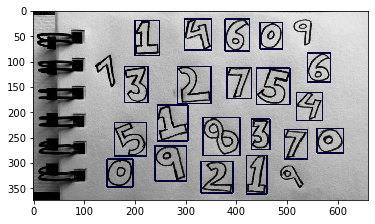

In [98]:
imgOrigin = img.copy()
for (startX, startY, endX, endY) in pick:
    imgOrigin = cv2.rectangle(imgOrigin, (startX, startY), (endX, endY), (0, 2, 55, 0), 2)
plt.imshow(imgOrigin)

# crop image

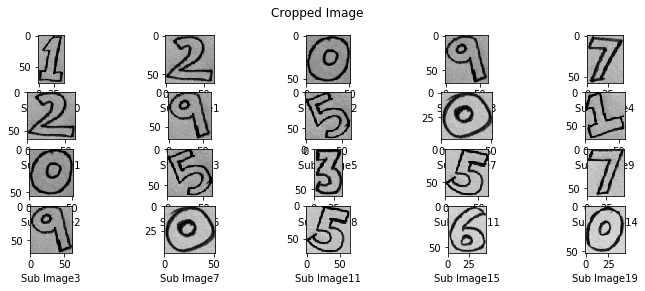

In [104]:
def _cropImage(x1, y1, x2, y2, img):
    if np.ndim(img) == 3 :
        crop = img[y1:y2, x1:x2, :]
    else:
        crop = img[y1:y2, x1:x2]
    return crop 
crop_image = [_cropImage(x1, y1, x2, y2, img) for (x1, y1, x2, y2) in pick]
fg, ax = plt.subplots(4,5,figsize=(12, 4))
fg.suptitle('Cropped Image')

for i in np.arange(4):
    for j in np.arange(5):
        try:
            ax[i,j].imshow(crop_image[i+j+j*i])
            ax[i,j].set_xlabel('Sub Image' + str(i+j+j*i))
        except:
            next